# GraphMemory Q&A — QuickStart (Notebook)

Ten notatnik pokazuje, jak **testować chatbota korzystającego z Twojej pamięci grafowej (GraphMem)** na danych FAQ.

## Wymagania wstępne
1. Otwórz ten notatnik **w katalogu głównym repo** `chatbot-for-bank-main/`.
2. Upewnij się, że do repo zostały dodane pliki z paczki: `memory_qa.py` oraz `adapters/faq_ingest_adapter.py`.
   - Jeżeli jeszcze ich nie masz, rozpakuj paczkę `memory_qa_patch.zip` do katalogu repo.
3. Zależności: tylko `numpy`.


In [1]:
# ✅ Setup: ścieżki i zależności
import sys, os
from pathlib import Path

repo_root = Path.cwd()
sys.path.insert(0, str(repo_root))

req = []
try:
    import numpy  # noqa: F401
except Exception as e:
    req.append('numpy')

if req:
    # Zainstaluj brakujące zależności w środowisku notatnika
    import sys, subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', *req])

# Pliki wymagane do działania
assert (repo_root/"memory_qa.py").exists(), "Brak memory_qa.py — rozpakuj memory_qa_patch.zip do repo." 
assert (repo_root/"adapters"/"faq_ingest_adapter.py").exists(), "Brak adapters/faq_ingest_adapter.py — rozpakuj memory_qa_patch.zip do repo." 
assert (repo_root/"data"/"banking_faq_30plus.txt").exists(), "Brak data/banking_faq_30plus.txt — sprawdź dane w repo."
print('✅ Środowisko gotowe.')


✅ Środowisko gotowe.


In [2]:
# 🚀 Inicjalizacja bota Q&A z pamięci grafowej
from memory_qa import build_bot_from_faq
bot = build_bot_from_faq("data/banking_faq_30plus.txt", alpha=0.7, min_sim=0.35)
len(bot.gm.facts)


1

In [3]:
# 🔎 Pomocnicza funkcja do zapytań i podglądu kandydatów
from pprint import pprint
def ask(q: str, k: int = 5):
    r = bot.answer(q)
    print('\nQ:', q)
    print('A:', r["answer"])    
    if 'matched_question' in r:
        print('Matched Q:', r['matched_question'])
    if 'category' in r and r['category']:
        print('Category:', r['category'])
    print('score=', r.get('score'), 'sim=', r.get('sim'), 'recency=', r.get('recency'))
    if r.get('alternatives'):
        print('\nAlternatywy:')
        for alt in r['alternatives']:
            print('-', alt['question'], '| score', alt['score'])
    return r

print('Gotowe. Użyj: ask("Jak zgłosić spór do transakcji kartą?")')


Gotowe. Użyj: ask("Jak zgłosić spór do transakcji kartą?")


In [4]:
# 🧪 Szybkie testy
ask("Jak zgłosić spór do transakcji kartą?")
ask("Jak zmienić PIN do karty?")
ask("Chcę zastrzec kartę")



Q: Jak zgłosić spór do transakcji kartą?
A: Chargeback to proces zwrotu środków dla posiadacza karty w przypadku sporu z transakcją kartową. Bank inicjuje postępowanie wobec organizacji płatniczej i sprzedawcy w celu odzyskania pieniędzy.
Matched Q: Co to jest chargeback?
Category: chargeback
score= 0.608 sim= 0.446 recency= 0.987

Q: Jak zmienić PIN do karty?
A: Chargeback to proces zwrotu środków dla posiadacza karty w przypadku sporu z transakcją kartową. Bank inicjuje postępowanie wobec organizacji płatniczej i sprzedawcy w celu odzyskania pieniędzy.
Matched Q: Co to jest chargeback?
Category: chargeback
score= 0.551 sim= 0.364 recency= 0.987

Q: Chcę zastrzec kartę
A: Nie mam pewnej odpowiedzi w pamięci. Spróbuj doprecyzować pytanie lub użyj innego sformułowania.
score= None sim= None recency= None


{'answer': 'Nie mam pewnej odpowiedzi w pamięci. Spróbuj doprecyzować pytanie lub użyj innego sformułowania.',
 'candidates': [{'preview': ['[CATEGORY] chargeback',
    'Q: Co to jest chargeback?'],
   'score': 0.519,
   'sim': 0.318,
   'recency': 0.987,
   'category': 'chargeback',
   'question': 'Co to jest chargeback?'}]}

In [5]:
# ⚙️ Strojenie: wpływ parametrów alpha oraz min_sim
from memory_qa import MemoryQABot
from adapters.faq_ingest_adapter import ingest_faq_to_graph
from graph_mem import GraphMem
import numpy as np

def rebuild_bot(alpha=0.7, min_sim=0.35):
    gm = GraphMem()
    ingest_faq_to_graph("data/banking_faq_30plus.txt", gm)
    return MemoryQABot(gm, alpha=alpha, min_sim=min_sim)

bot = rebuild_bot(alpha=0.5, min_sim=0.3)
ask("Jak zgłosić spór do transakcji kartą?")



Q: Jak zgłosić spór do transakcji kartą?
A: Chargeback to proces zwrotu środków dla posiadacza karty w przypadku sporu z transakcją kartową. Bank inicjuje postępowanie wobec organizacji płatniczej i sprzedawcy w celu odzyskania pieniędzy.
Matched Q: Co to jest chargeback?
Category: chargeback
score= 0.723 sim= 0.446 recency= 1.0


{'answer': 'Chargeback to proces zwrotu środków dla posiadacza karty w przypadku sporu z transakcją kartową. Bank inicjuje postępowanie wobec organizacji płatniczej i sprzedawcy w celu odzyskania pieniędzy.',
 'category': 'chargeback',
 'matched_question': 'Co to jest chargeback?',
 'score': 0.723,
 'sim': 0.446,
 'recency': 1.0,
 'alternatives': []}

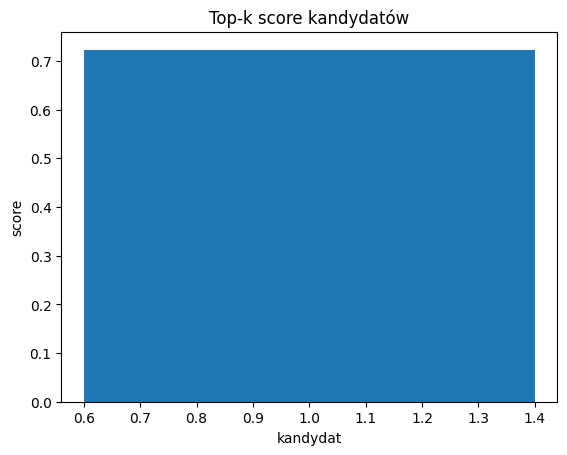

In [6]:
# 📊 (Opcjonalnie) Prosta wizualizacja top-k kandydatów dla jednego pytania
import matplotlib.pyplot as plt
res = bot.retrieve("Jak zgłosić spór do transakcji kartą?", k=5)
xs = list(range(1, len(res)+1))
ys = [c.score for c in res]
plt.figure()
plt.title("Top-k score kandydatów")
plt.bar(xs, ys)
plt.xlabel('kandydat')
plt.ylabel('score')
plt.show()
